In [1]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization, Activation
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import class_weight
import keras
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 224

IMG_DIR = '../project/eval_data/all_females_combined_train_s'
RATING_PATH = '../project/eval_data/all_females_combined_train_s/train_ratings.txt'

VAL_IMG_DIR = '../project/eval_data/all_females_combined_test_s'
VAL_RATING_PATH = '../project/eval_data/all_females_combined_test_s/test_ratings.txt'

VERSION = 'eval-Regr-comb'

In [3]:
def getMean(train_data):
    #calculate mean values for pixels (RGB)

    data = np.zeros((train_data.shape[0], IMG_SIZE, IMG_SIZE, 3)) 
    for i in range(train_data.shape[0]):
        _img = image.load_img(os.path.join(IMG_DIR, train_data[i]), target_size=(IMG_SIZE,IMG_SIZE))
        data[i,:,:,:] = image.img_to_array(_img)
    mean = np.mean(data, axis=(0, 1, 2))
    print("Pixel means: ",mean)

    return mean

In [4]:
def preprocess(x,mean):
    x[:,:,0] -= mean[0]
    x[:,:,1] -= mean[1]
    x[:,:,2] -= mean[2]

In [5]:
def prepareDataRegression(percentage):
    # Read in ratings
    ratings = np.genfromtxt(RATING_PATH)
        
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    

    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean)# / .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean)# / .255
            last_set_train += 1
    
    return data_train, ratings[train_ind], data_test, ratings[test_ind], ratings, mean

In [6]:
def prepareDataClassification(percentage):
    # Read in ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Round (obviously imbalanced sets)
    ratings_rounded = np.round(ratings, 0).astype(np.int8)
    ratings = to_categorical(ratings_rounded, num_classes=len(np.unique(ratings)))
    
                
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)

    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean)# / .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1)#preprocess(_x,mean)# / .255
            last_set_train += 1
    
    return data_train, ratings[train_ind], data_test, ratings[test_ind], ratings_rounded, mean
    #return ratings[train_ind], train_ind, ratings[test_ind], test_ind, ratings, images

In [7]:
def prepareDataOrdinalRegression(percentage):
    # Load ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))
    #remove train_ratings.txt from images
    images.remove('train_ratings.txt')
    #convert to np.array for indexing
    images = np.array(images)

    ### Make sure lengths of ratings and images correspond 
    print(len(ratings))
    print(len(images))
    assert len(ratings) == len(images)
    
    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    mean = getMean(images[train_ind])
    
    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = preprocess(_x,mean)#utils.preprocess_input(_x, version=1)# / .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = preprocess(_x,mean)#utils.preprocess_input(_x, version=1)# / .255
            last_set_train += 1
    
    
    return data_train, ratings_prepared[train_ind], data_test, ratings_prepared[test_ind], ratings_rounded, mean

In [8]:
def getGenerator(data_train, data_test):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
                                      )#preprocessing_function=utils.preprocess_input)

    train_datagen.fit(data_train)
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(data_test)

    return train_datagen, test_datagen

In [9]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def visualize_acc(history):
    loss = history.history['mean_absolute_error']
    val_loss = history.history['val_mean_absolute_error']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training mean_absolute_error")
    plt.plot(epochs, val_loss, 'r', label="Validation mean_absolute_error")
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

In [11]:
def recommend(images, pred_classes):
    if type(images) is np.ndarray: 
        images = images.tolist()
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(IMG_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

def recommendVal(images, pred_classes):
    if type(images) is np.ndarray: 
        images = images.tolist()
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        img = mpimg.imread(os.path.join(VAL_IMG_DIR, images[i]))
        imgplot = plt.imshow(img)
        plt.show()
        plt.clf()

### Get data

In [12]:
x_train, y_train, x_test, y_test, ratings, mean = prepareDataRegression(5)
train_generator, test_generator = getGenerator(x_train,x_test)

train_inst = x_train.shape[0]
print("x_train: ",x_train.shape)
print("y_train: ",y_train.shape)
print("x_test: ",x_test.shape)
print("y_test: ",y_test.shape)
print("ratings",ratings.shape)


Pixel means:  [159.87636903 133.18557324 119.61463087]
x_train:  (647, 224, 224, 3)
y_train:  (647,)
x_test:  (34, 224, 224, 3)
y_test:  (34,)
ratings (681,)


### Build keras model

In [13]:
# Add custom layers
vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
X = Dense(256, activation=None, name='fc6')(last_layer)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(128, activation=None, name='fc7')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation=None, name='fc8')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.2)(X)
X = Dense(1, activation=None)(X)
X = BatchNormalization()(X)
output = Activation('linear')(X)
model = Model(inputs=vgg_base.input, outputs=output)

# Freeze vgg layers
for layer in vgg_base.layers:
    layer.trainable = False

# Compute class weights since we have unbalaned classes
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ratings), 
                                                 ratings)

print(class_weight)

model.compile(optimizer=Adam(lr= 0.0005,clipnorm=1.0),
              #loss='categorical_crossentropy', 
              #metrics=['accuracy'])
              loss='mean_absolute_error', metrics=['mae'])

checkpointer = ModelCheckpoint(filepath='./weights-' + VERSION + '.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

[ 0.95378151  1.21390374  0.83455882  0.74183007  0.44509804  0.51357466
  0.66764706  0.74183007  0.95378151  0.53411765  0.74183007  0.58056266
  0.47689076  1.21390374  0.51357466  0.70278638  0.63585434  1.33529412
  1.66911765  2.2254902   0.78546713  1.66911765  0.78546713  1.66911765
  0.63585434  1.66911765  1.1127451   0.89019608  1.48366013  1.21390374
  0.95378151  2.67058824  1.21390374  1.48366013  0.66764706  0.83455882
  0.89019608  1.48366013  1.1127451   1.66911765  1.48366013  1.48366013
  1.1127451   1.33529412  2.67058824  1.90756303  1.1127451   4.45098039
  2.67058824 13.35294118 13.35294118]


In [14]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=train_inst//32,
    epochs=500,
    class_weight=class_weight,
    validation_data=test_generator.flow(x_test, y_test, batch_size=32),
    callbacks=[earlystop, checkpointer]
)

Epoch 1/500
20/20 [==============================] - 13s 661ms/step - loss: 2.1492 - mean_absolute_error: 2.1492 - val_loss: 2.3340 - val_mean_absolute_error: 2.3340

Epoch 00001: val_loss improved from inf to 2.33397, saving model to ./weights-eval-Regr-comb.hdf5
Epoch 2/500
20/20 [==============================] - 8s 403ms/step - loss: 2.1109 - mean_absolute_error: 2.1109 - val_loss: 2.7174 - val_mean_absolute_error: 2.7174

Epoch 00002: val_loss did not improve
Epoch 3/500
20/20 [==============================] - 8s 401ms/step - loss: 2.1080 - mean_absolute_error: 2.1080 - val_loss: 2.5668 - val_mean_absolute_error: 2.5668

Epoch 00003: val_loss did not improve
Epoch 4/500
20/20 [==============================] - 8s 399ms/step - loss: 2.0571 - mean_absolute_error: 2.0571 - val_loss: 2.8734 - val_mean_absolute_error: 2.8734

Epoch 00004: val_loss did not improve
Epoch 5/500
20/20 [==============================] - 8s 403ms/step - loss: 2.0533 - mean_absolute_error: 2.0533 - val_loss:

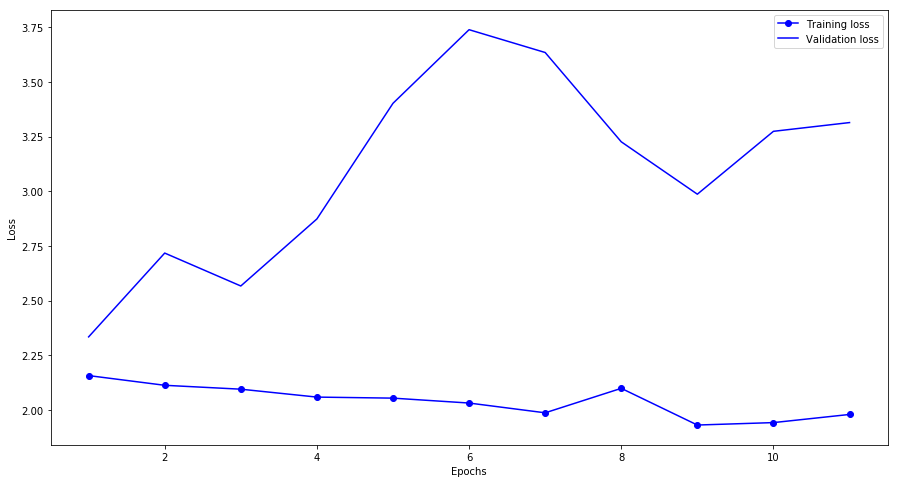

In [15]:
visualize_loss(history)

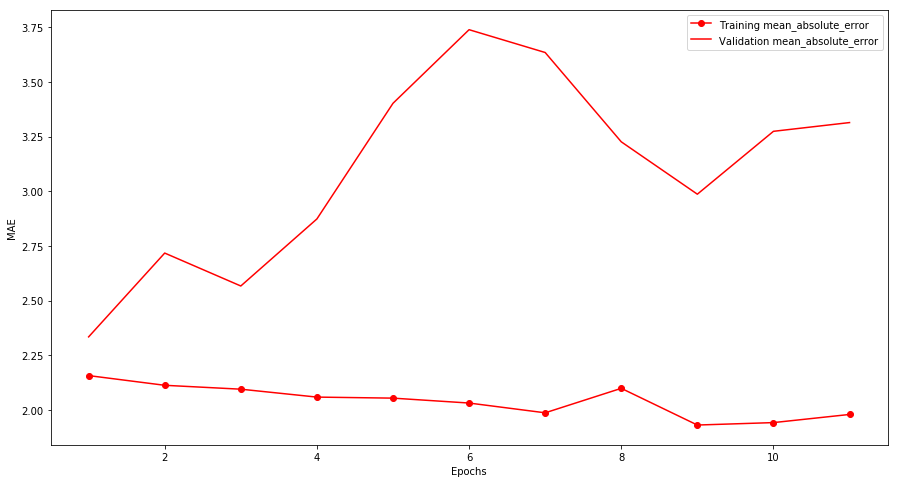

In [16]:
visualize_acc(history)

In [17]:
model.save('./models/love_classifier' + VERSION + '.h5')

### Predictions: Test set

In [18]:
predictions = model.predict(x_test)

pred_classes = predictions
y_true = y_test

print(y_true)
print(pred_classes)

print(model.metrics_names)
print(model.evaluate(x_test,y_test))

[0.8 3.2 1.5 1.4 1.6 1.6 3.5 1.2 1.2 0.5 1.1 3.3 1.7 4.  4.3 1.5 3.2 2.4
 0.9 1.4 2.4 2.1 1.1 3.5 1.4 2.9 4.3 2.9 1.4 0.5 1.2 2.7 0.5 2. ]
[[-3591.6443]
 [-3702.874 ]
 [-2953.2   ]
 [-3345.0146]
 [-3660.401 ]
 [-3093.3884]
 [-2514.8962]
 [-2233.0137]
 [-2568.3713]
 [-1587.8575]
 [-2070.8923]
 [-2478.8098]
 [-1690.6996]
 [-1759.1506]
 [-3594.8062]
 [-2528.6301]
 [-2249.5505]
 [-2359.228 ]
 [-3220.8462]
 [-2096.6494]
 [-3333.537 ]
 [-2404.1187]
 [-1452.7673]
 [-1966.7227]
 [-2591.2227]
 [-1811.1538]
 [-3291.2144]
 [-2092.2593]
 [-2110.7305]
 [-2492.479 ]
 [-2719.766 ]
 [-1544.0077]
 [-1916.5792]
 [-1284.4976]]
['loss', 'mean_absolute_error']
34/34 [==============================] - 0s 12ms/step
[2481.7701775045957, 2481.7701775045957]


In [19]:
#recommend(x_test,pred_classes)

### Prediction: Validation set

In [20]:
def prepareValData(mean):
    # Load ratings
    ratings = np.genfromtxt(VAL_RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(VAL_IMG_DIR))
    #remove val_ratings.txt from images
    images.remove('test_ratings.txt')

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)
    
    data = np.zeros((len(images), IMG_SIZE, IMG_SIZE, 3)) 
    last_set = 0
    
    for idx, _im in enumerate(images): #iterate over images
        _img = image.load_img(os.path.join(VAL_IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
        _x = image.img_to_array(_img)
        _x = np.expand_dims(_x, axis=0)
        data[last_set, :, :, :] = preprocess(_x,mean)#utils.preprocess_input(_x, version=1) / .255
        last_set += 1
    
    return data, ratings

In [21]:
x_val, ratings_val = prepareValData(mean)

predictions = model.predict(x_val)

pred_classes = predictions
y_true = ratings_val

print(y_true)
print(pred_classes)

print(model.metrics_names)
print(model.evaluate(x_val,ratings_val))

[0.  0.3 0.3 0.4 0.4 0.4 0.4 0.8 0.9 1.  1.2 1.3 1.4 1.4 1.5 1.9 2.  2.2
 2.2 2.4 2.5 2.7 2.9 3.  3.  3.2 3.3 3.4 3.5 3.6 3.8 3.8 3.9 4.4 4.5 4.6
 4.6]
[[0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.5699562 ]
 [0.56995606]
 [0.56995606]
 [0.56995606]
 [0.56995606]
 [0.56995606]]
['loss', 'mean_absolute_error']
37/37 [==============================] - 0s 13ms/step
[1.7727299252071895, 1.7727299252071895]


In [22]:
#recommend(x_test,pred_classes)

In [23]:
print(model.evaluate(x_train,y_train))

647/647 [==============================] - 8s 12ms/step
[2376.1459908109546, 2376.1459908109546]
